# JAX random package
- https://jax.readthedocs.io/en/latest/jax.random.html

## Design and Context
Among other requirements, the JAX PRNG aims to:
1. ensure reproducibility,
2. parallelize well, both in terms of vectorization (generating array values) and multi-replica, multi-core computation. In particular it should not use sequencing constraints between random function calls.

## Basic usage
```python
>>> key = jax.random.PRNGKey(seed)
>>> for i in range(num_steps):
...   key, subkey = jax.random.split(key)
...   params = compiled_update(subkey, params, next(batches))
```

## PRNG Keys
Unlike the stateful pseudorandom number generators (PRNGs) that users of NumPy and SciPy may be accustomed to, JAX random functions all require an **explicit** PRNG state to be passed as a first argument. The random state is described by two unsigned 32-bit integers that we call a key, usually generated by the `jax.random.PRNGKey()` function:
```python
>>> from jax import random
>>> key = random.PRNGKey(0)
>>> key
DeviceArray([0, 0], dtype=uint32)
```
This key can then be used in any of JAX’s random number generation routines:
```python
>>> random.uniform(key)
DeviceArray(0.41845703, dtype=float32)
```
Note that using a key does not modify it, so reusing the same key will lead to the same result:
    
```python
>>> random.uniform(key)
DeviceArray(0.41845703, dtype=float32)
```
If you need a new random number, you can use `jax.random.split()` to generate new subkeys:
```python
>>> key, subkey = random.split(key)
>>> random.uniform(subkey)
DeviceArray(0.10536897, dtype=float32)
```

# Coin Flips: Random Generation from Bernoulli Distribution

When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. ``It looks very suspicious to me," said Barry Blight, a statistics lecturer at the London School of Economics.

- Let's simulate the coin flip experiments.
- Let's try to find an estimate of the probability of head.

In [19]:
import numpyro
import numpyro as npr
import jax
import jax.random as random
import jax.numpy as jnp
import jax.scipy.stats as stats
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")



In [50]:
key = jax.random.PRNGKey(0)
def rkey():  ## produce a new key
    key, subkey = jax.random.split(key)
    return subkey
#
jax.__version__

'0.2.8'

## Simulation

In [21]:
p = 0.5

In [22]:
u = jax.random.uniform(key)  # generate from uniform distribution U[0,1]
X = 1 if u <= p else 0

print(X, u)

1 0.41845703


In [38]:
stats.bernoulli.pmf(key, p=p)

DeviceArray([0.5, 0.5], dtype=float32)

[0 1] [0.5 0.5]


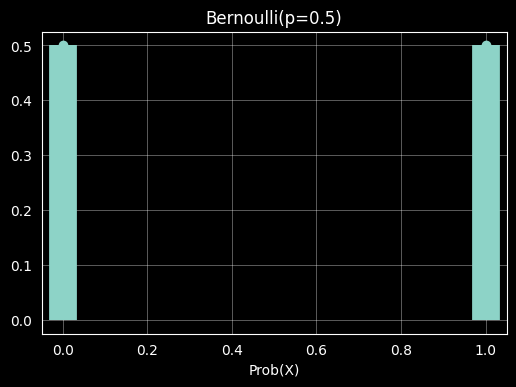

In [25]:
x = jnp.array([0, 1])
P = stats.bernoulli.pmf(key, p=p)
print(x, P)
markers, stems, base = plt.stem(x, P); 
stems.set_linewidth(20); base.set_linewidth(0)
plt.title(f'Bernoulli(p={p})'); plt.xlabel('Prob(X)');

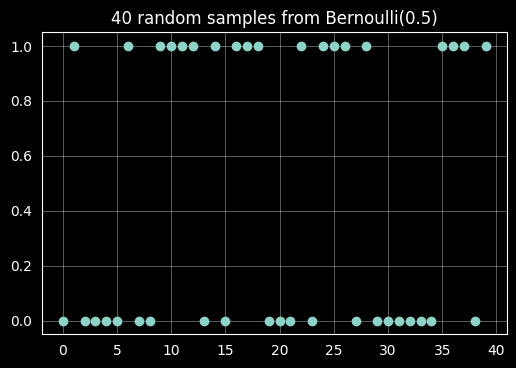

In [43]:
X = jax.random.bernoulli(key, p=p, shape=[40])
plt.plot(X, 'o'); plt.title('40 random samples from Bernoulli(0.5)');

## Mean & Std
1. Theoretically, 
    $$
        \begin{align}
            \mu &= \mathbb{E}[X] = \sum_{X\in\{0,1\}} X P(X) = p, \\
            \sigma &= \mathbb{E}[(X-\mu)^2] = pq
        \end{align}
    $$
1. Generate many samples and compute the average. It is called `sample mean`. 
2. Std = sample standard deviation

In [53]:
n_samples = 10000
X = jax.random.bernoulli(key, p=0.5, shape=[n_samples])
mean = X.sum()/n_samples
std = jnp.sqrt( ((X - mean)*(X-mean)).sum() / n_samples )
print(f'mean={mean}  std={std}; or  {X.mean()} & {X.std()}')

mean=0.4948999881744385  std=0.49997395277023315; or  0.4948999881744385 & 0.49997395277023315


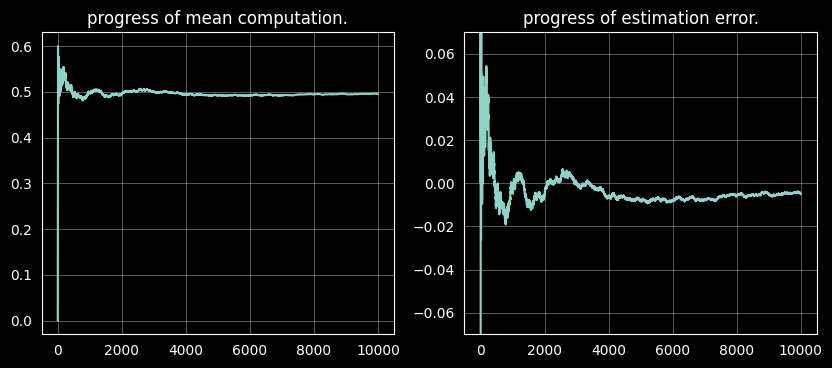

In [54]:
csum = X.cumsum();
p_est = jnp.array([ cs / (k+1) for k, cs in enumerate(csum)])
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(range(n_samples), p_est); axes[0].set_title(f'progress of mean computation.')
axes[1].plot(range(n_samples), p_est - p); axes[1].set_title('progress of estimation error.')
axes[1].set_ylim(-0.07, 0.07); 

## Simulate 250 Bernoulli samples

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html

In [55]:
p = 0.5
ntotal = 250
nheads = 140

In [57]:
X = jax.random.bernoulli(key, p=p, shape=[ntotal]); print(f'{X.shape}, Heads: {X.sum()}')

(250,), Heads: 136


In [58]:
repeat = 100000
# slow, do not try
# heads_simul = [stats.bernoulli(p=p).rvs(ntotal).sum() for i in range(repeat)] 

The proportion that # of heads is over 140 is 3.378000020980835%


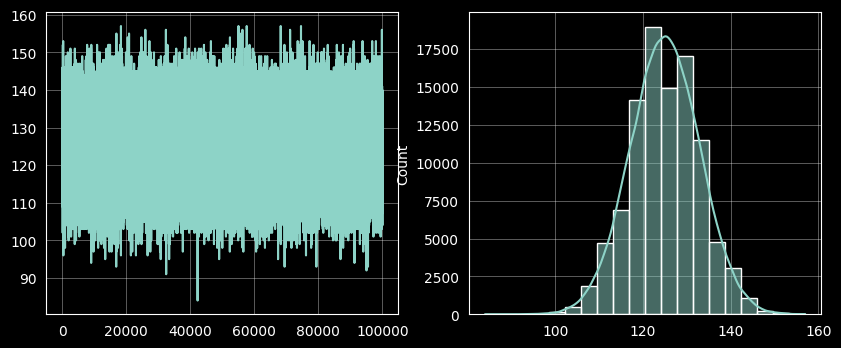

In [60]:
X = jax.random.bernoulli(key, p=p, shape=(repeat, ntotal))
heads_simul = X.sum(axis=1)
over_140 = heads_simul >= nheads
print(f'The proportion that # of heads is over 140 is {over_140.sum() * 100 / repeat}%')
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(heads_simul); 
sns.histplot(heads_simul, kde=True, bins=20);

## Simulate 250 Bernoulli samples, p=.55

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html

In [61]:
p = 0.55

In [62]:
repeat = 100000

The proportion that # of heads is over 140 is 40.21799850463867%


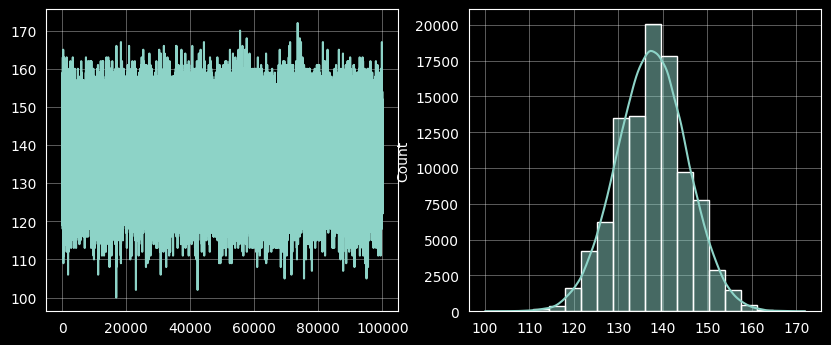

In [63]:
X = jax.random.bernoulli(key, p=p, shape=(repeat, ntotal))
heads_simul = X.sum(axis=1)
over_140 = heads_simul >= nheads
print(f'The proportion that # of heads is over 140 is {over_140.sum() * 100 / repeat}%')
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(heads_simul); sns.histplot(heads_simul, kde=True, bins=20);

## Estimation of p with uniform prior

In [71]:
probs = jnp.linspace(.49, .60, 12)
prior = jnp.ones_like(probs) / len(probs)
log_prior = jnp.log( prior )
print(f'candidate p: {probs}\nprior probability: {prior}')
print('log_prior:', log_prior)

candidate p: [0.49       0.5        0.51       0.52000004 0.53000003 0.53999996
 0.55       0.56000006 0.57000005 0.58000004 0.59000003 0.6       ]
prior probability: [0.08333334 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334
 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334]
log_prior: [-2.4849067 -2.4849067 -2.4849067 -2.4849067 -2.4849067 -2.4849067
 -2.4849067 -2.4849067 -2.4849067 -2.4849067 -2.4849067 -2.4849067]


In [65]:
# for each hypothesis p, we comput
likelihood = jnp.array([p**140 * (1-p)**110 for p in probs])
likelihood

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [75]:
# Using 64bit float is tricky and not recommended because contemporary 
# GPUs for deep learning rely on 32bit float computation
likelihood = jnp.array([p**140 * (1-p)**110 for p in probs], dtype=jnp.float64)
likelihood

/home/yndk/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2796: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [66]:
likelihood[0] == 0.0  # what?

DeviceArray(True, dtype=bool)

* We have to be smart in terms of the resolution of float

In [68]:
log_likelihood = jnp.array([jnp.log(p) * 140 + jnp.log(1-p) * 110 for p in probs])
log_likelihood

DeviceArray([-173.93689, -173.2868 , -172.73672, -172.28632, -171.93544,
             -171.68423, -171.53302, -171.48245, -171.53336, -171.68686,
             -171.94438, -172.30756], dtype=float32)

In [69]:
jnp.exp(log_likelihood)

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [73]:
log_posterior_unnormalized = log_prior + log_likelihood
log_posterior_unnormalized

DeviceArray([-176.4218 , -175.77171, -175.22163, -174.77122, -174.42035,
             -174.16914, -174.01793, -173.96736, -174.01826, -174.17177,
             -174.42929, -174.79247], dtype=float32)

The numbers may be scaled during the computation

post = post_un / sum(post_un)
log(post) = log(post_un) - log(sum(post_un))

post = post_un * scale / sum(post_un*scale)
log(post) = log(post_un) + log(scale) - log(sum(post_un*scale)) = log(post_un) - log(sum(post_un))

**Procedure**
1. compute: log_post_un_scaled = log(post_un) + alpha  for some number alpha
2. compute: post_scaled_un = exp(log_post_un_scaled)
3. compute: Z = sum_i exp(post_scaled_un_i)
4. normalize: post = post_scaled_un / Z

In [74]:
log_posterior_un_scaled = log_posterior_unnormalized - log_posterior_unnormalized.max()
posterior_scaled_un = jnp.exp(log_posterior_un_scaled)
Z = posterior_scaled_un.sum()
posterior = posterior_scaled_un / Z
posterior

DeviceArray([0.01189776, 0.02279259, 0.03950845, 0.06198693, 0.08804072,
             0.11318287, 0.13165954, 0.13848847, 0.13161536, 0.11288621,
             0.08725699, 0.0606842 ], dtype=float32)

In [76]:
istar = jnp.argmax(posterior)
pstar = probs[istar]
print(f'* best estimate is {pstar}')

* best estimate is 0.5600000619888306


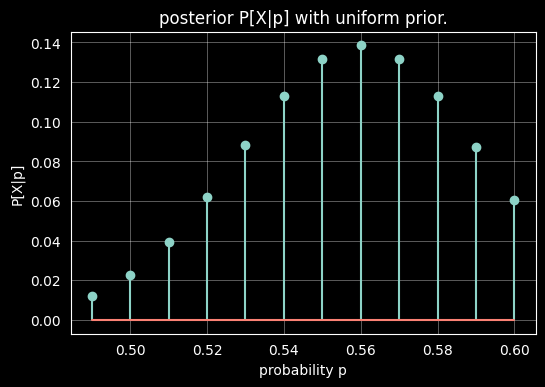

In [77]:
plt.stem(probs, posterior);
plt.xlabel('probability p')
plt.ylabel('P[X|p]')
plt.title('posterior P[X|p] with uniform prior.');

In [79]:
likelihood_scaled = jnp.exp(log_likelihood - log_likelihood.max())

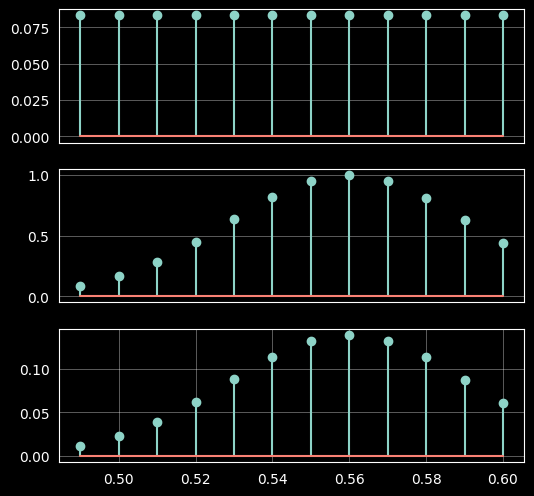

In [80]:
fig, axes = plt.subplots(3,1, figsize=(6,6))
for ax, pdf in zip(axes, [prior, likelihood_scaled, posterior]):
    ax.stem(probs, pdf)
axes[0].set_xticks([]); axes[1].set_xticks([]); 

## Estimation of p with triangular prior

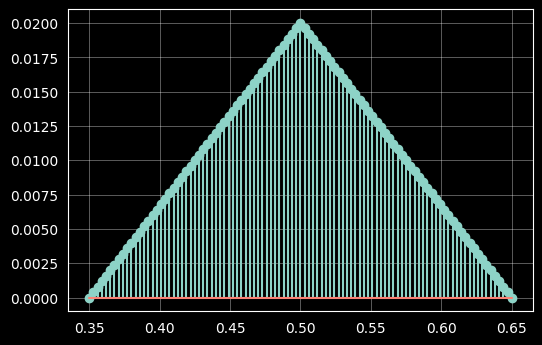

In [87]:
probs = jnp.linspace(.35, .65, 101)
m = len(probs)//2
import numpy as np  # jax.numpy is immutable
prior = np.empty_like(probs)
prior[:m] = np.array([(1 - 0)/(probs[m] - probs[0])*(p - probs[0]) for p in probs[:m]])
prior[m:] = np.array([(0 - 1)/(probs[-1] - probs[m])*(p - probs[m]) + 1 for p in probs[m:]])
prior = jnp.array(prior / prior.sum())
plt.stem(probs, prior);

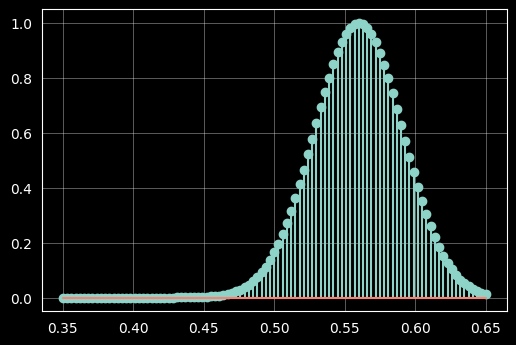

In [89]:
# for each hypothesis p, we comput
log_likelihood = jnp.array([jnp.log(p)*140 + jnp.log(1-p)*110 for p in probs])
likelihood = jnp.exp(log_likelihood - log_likelihood.max())
plt.stem(probs, likelihood);

In [90]:
posterior_unnormalized = prior * likelihood
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior

DeviceArray([0.00000000e+00, 2.93896987e-13, 1.15277232e-12,
             3.34960466e-12, 8.54666338e-12, 2.01992780e-11,
             4.52881760e-11, 9.75610981e-11, 2.03493097e-10,
             4.13029055e-10, 8.18565660e-10, 1.58800062e-09,
             3.02124725e-09, 5.64526514e-09, 1.03713207e-08,
             1.87518445e-08, 3.33908439e-08, 5.85965658e-08,
             1.01394093e-07, 1.73081787e-07, 2.91576754e-07,
             4.84924499e-07, 7.96457641e-07, 1.29219086e-06,
             2.07145399e-06, 3.28187434e-06, 5.13956047e-06,
             7.95780124e-06, 1.21841813e-05, 1.84494766e-05,
             2.76337996e-05, 4.09467502e-05, 6.00303974e-05,
             8.70837612e-05, 1.25020801e-04, 1.77640846e-04,
             2.49835051e-04, 3.47824098e-04, 4.79394745e-04,
             6.54159405e-04, 8.83823785e-04, 1.18242542e-03,
             1.56648899e-03, 2.05522194e-03, 2.67037540e-03,
             3.43646575e-03, 4.38020239e-03, 5.52995456e-03,
             6.91558793e

In [91]:
istar = np.argmax(posterior)
pstar = probs[istar]
print(f'* best estimate is {pstar}')

* best estimate is 0.5509999990463257


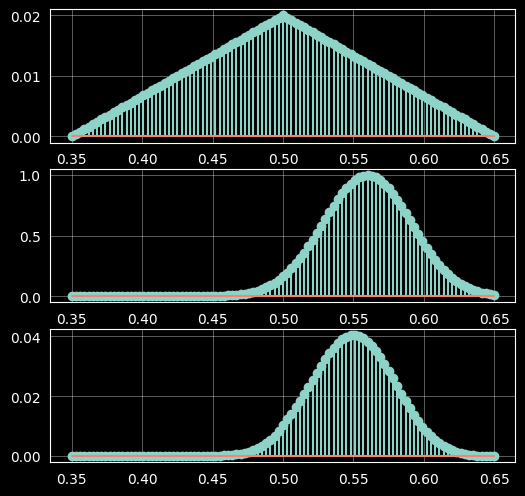

In [92]:
fig, axes = plt.subplots(3,1, figsize=(6,6))
for ax, pdf in zip(axes, [prior, likelihood, posterior]):
    ax.stem(probs, pdf)

## Estimation of p with Grids from Beta($\alpha$, $\beta$)

In [97]:
jax.scipy.stats.beta.pdf(probs, alpha, beta)

DeviceArray([0.        , 0.11760006, 0.23040007, 0.33840013, 0.4416001 ,
             0.5400002 , 0.63360023, 0.7224003 , 0.8064003 , 0.8856003 ,
             0.96000034, 1.0296004 , 1.0944004 , 1.1544003 , 1.2096004 ,
             1.2600005 , 1.3056005 , 1.3464006 , 1.3824004 , 1.4136006 ,
             1.4400005 , 1.4616008 , 1.4784006 , 1.4904006 , 1.4976006 ,
             1.5000006 , 1.4976007 , 1.4904006 , 1.4784006 , 1.4616005 ,
             1.4400005 , 1.4136006 , 1.3824004 , 1.3464005 , 1.3056005 ,
             1.2600005 , 1.2096003 , 1.1544003 , 1.0944005 , 1.0296005 ,
             0.96000034, 0.8856003 , 0.8064005 , 0.7224003 , 0.63360023,
             0.5400003 , 0.44160002, 0.33840013, 0.23040023, 0.11759995,
             0.        ], dtype=float32)

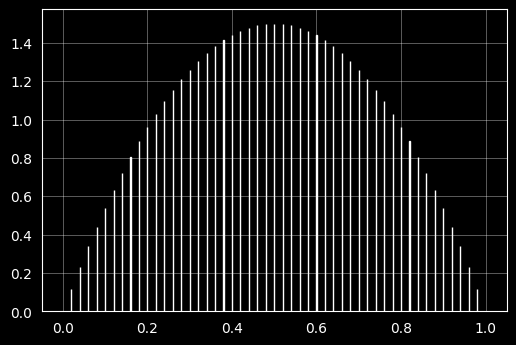

In [122]:
eps = 0  ##1E-7   # set this to 0 and see the values of posterior
probs = jnp.linspace(.0+eps, 1.-eps, 51)  # beta distribution is not defined for {0, 1}

alpha, beta = 2, 2
prior = jax.scipy.stats.beta.pdf(probs, alpha, beta)

width = 0.0001
plt.bar(probs, prior, width=width);

In [131]:
print(prior)

[0.         0.11760006 0.23040007 0.33840013 0.4416001  0.5400002
 0.63360023 0.7224003  0.8064003  0.8856003  0.96000034 1.0296004
 1.0944004  1.1544003  1.2096004  1.2600005  1.3056005  1.3464006
 1.3824004  1.4136006  1.4400005  1.4616008  1.4784006  1.4904006
 1.4976006  1.5000006  1.4976007  1.4904006  1.4784006  1.4616005
 1.4400005  1.4136006  1.3824004  1.3464005  1.3056005  1.2600005
 1.2096003  1.1544003  1.0944005  1.0296005  0.96000034 0.8856003
 0.8064005  0.7224003  0.63360023 0.5400003  0.44160002 0.33840013
 0.23040023 0.11759995 0.        ]


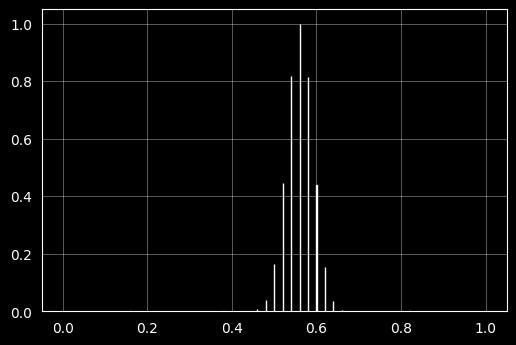

In [123]:
# for each hypothesis p, we compute
log_likelihood = jnp.array([jnp.log(p)*140 + jnp.log(1-p)*110 for p in probs])
log_likelihood -= log_likelihood.max()  # scale for numerical stability
likelihood = jnp.exp(log_likelihood)
plt.bar(probs, likelihood, width=width);

In [132]:
print(log_likelihood)

[          -inf -3.7842307e+02 -2.8365060e+02 -2.2920135e+02
 -1.9129153e+02 -1.6246912e+02 -1.3941614e+02 -1.2036386e+02
 -1.0425781e+02 -9.0418915e+01 -7.8384659e+01 -6.7826172e+01
 -5.8501892e+01 -5.0229431e+01 -4.2868195e+01 -3.6307983e+01
 -3.0461227e+01 -2.5257599e+01 -2.0640305e+01 -1.6563248e+01
 -1.2989059e+01 -9.8876038e+00 -7.2348633e+00 -5.0120544e+00
 -3.2051544e+00 -1.8043518e+00 -8.0386353e-01 -2.0178223e-01
  0.0000000e+00 -2.0440674e-01 -8.2510376e-01 -1.8768005e+00
 -3.3793793e+00 -5.3587646e+00 -7.8480682e+00 -1.0889053e+01
 -1.4534348e+01 -1.8850357e+01 -2.3921494e+01 -2.9856171e+01
 -3.6795822e+01 -4.4928497e+01 -5.4510971e+01 -6.5905182e+01
 -7.9643204e+01 -9.6552368e+01 -1.1802115e+02 -1.4665530e+02
 -1.8830890e+02 -2.6166855e+02           -inf]


In [126]:
posterior_unnormalized = prior * likelihood
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior[:10]

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [130]:
log_posterior_unnormalized = jnp.log(prior) + log_likelihood
print(log_posterior_unnormalized, jnp.exp(log_posterior_unnormalized))
posterior_unnormalized = jnp.exp(log_posterior_unnormalized - log_posterior_unnormalized.max())
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior

[           -inf -3.80563538e+02 -2.85118530e+02 -2.30284882e+02
 -1.92108887e+02 -1.63085297e+02 -1.39872482e+02 -1.20689034e+02
 -1.04472984e+02 -9.05404053e+01 -7.84254837e+01 -6.77970047e+01
 -5.84116859e+01 -5.00858498e+01 -4.26779060e+01 -3.60768700e+01
 -3.01945648e+01 -2.49601631e+01 -2.03164825e+01 -1.62171078e+01
 -1.26244164e+01 -9.50807190e+00 -6.84390259e+00 -4.61300945e+00
 -2.80129027e+00 -1.39888632e+00 -3.99999261e-01  1.97262675e-01
  3.90960842e-01  1.75125360e-01 -4.60460275e-01 -1.53066051e+00
 -3.05555773e+00 -5.06132984e+00 -7.58140516e+00 -1.06579409e+01
 -1.43440571e+01 -1.87067757e+01 -2.38312874e+01 -2.98269997e+01
 -3.68366432e+01 -4.50499878e+01 -5.47261467e+01 -6.62303543e+01
 -8.00995407e+01 -9.71685562e+01 -1.18838501e+02 -1.47738831e+02
 -1.89776840e+02 -2.63809021e+02            -inf] [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.71455435e-35 3.

DeviceArray([0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 1.50817762e-35, 6.22790872e-31,
             7.41881234e-27, 3.06336746e-23, 5.05159103e-20,
             3.71724975e-17, 1.33313575e-14, 2.50118719e-12,
             2.59938737e-10, 1.56749742e-08, 5.69498980e-07,
             1.28500287e-05, 1.84475255e-04, 1.71712821e-03,
             1.05104735e-02, 4.27246578e-02, 1.16008483e-01,
             2.10803241e-01, 2.55858213e-01, 2.06187904e-01,
             1.09202310e-01, 3.74498256e-02, 8.15070793e-03,
             1.09672977e-03, 8.82357999e-05, 4.06932486e-06,
             1.02014631e-07, 1.30004341e-09, 7.73411543e-12,
             1.92533316e-14, 1.73882712e-17, 4.71244351e-21,
             2.95762935e-25, 2.98352616e-30, 2.82760506e-36,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e

In [127]:
istar = np.argmax(posterior)
pstar = probs[istar]
print(f'* best estimate is {pstar}')

* best estimate is 0.5600000023841858


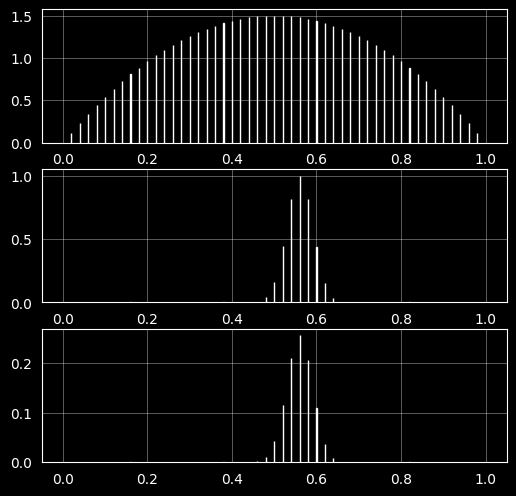

In [128]:
fig, axes = plt.subplots(3,1, figsize=(6,6))
for ax, pdf in zip(axes, [prior, likelihood, posterior]):
    ax.bar(probs, pdf, width=width)

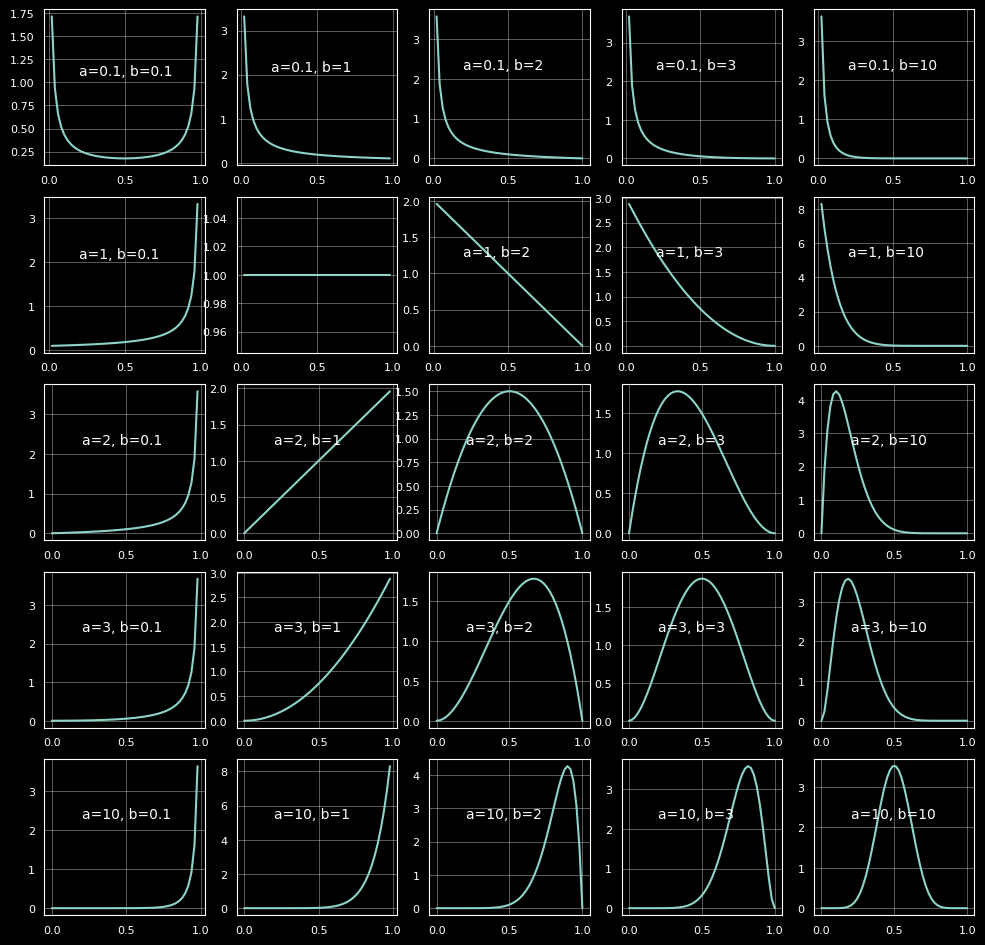

In [129]:
## Beta distribution
alphas = [0.1, 1, 2, 3, 10]
betas = [0.1, 1, 2, 3, 10]
p = np.linspace(0, 1, 50)
fig, axes = plt.subplots(5, 5, figsize=(12,12))
for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        ax = axes[i,j]
        pdf = jax.scipy.stats.beta.pdf(p, a, b)
        ax.plot(p, pdf)
        ax.tick_params(labelsize=8)
        ax.text(0.2, ax.get_ylim()[1]*.6, f'a={a}, b={b}')

End.